In [1]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys
import torchvision
import albumentations as A
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import math
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim import AdamW
from torch_optimizer import Ranger
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
torch.multiprocessing.set_sharing_strategy('file_descriptor')

/home/anton/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-28 07:27:16.461914: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 07:27:16.481835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 07:27:16.481855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 07:27:16.482444: E external/local_xla/xla/stream_exec

In [2]:
timm.__version__

'0.9.2'

In [3]:
rd = 'rsna-2024-lumbar-spine-degenerative-classification'

In [4]:
# Remember to change NOT_DEBUG to True for real training
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-cropped-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = 4
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 69

IMG_SIZE = [192, 192]
IN_CHANS = 12
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75
SELECTED_FOLDS = [2]
N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 100 if NOT_DEBUG else 2
# MODEL_NAME = "tf_efficientnet_b4.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"
# TODO: you can choose other convolutional neural network (CNN) architectures designed to 
#       achieve state-of-the-art accuracy in various computer vision tasks

# MODEL_NAME = "vit_base_patch16_siglip_512"
# MODEL_NAME = "efficientnet_b0"
MODEL_NAME = "convnext_pico.d1_in1k"
GRAD_ACC = 2
TGT_BATCH_SIZE = 6
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 15

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

In [7]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [8]:
df = df.fillna(-100)

In [9]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_13304/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
boxes = pd.read_csv('boxes.csv')
boxes

,filename,x1,y1,x2,y2,level
0,cvt_png/100206310/Sagittal T1/001.png,76,113,163,210,L5/S1
1,cvt_png/100206310/Sagittal T1/002.png,80,114,170,208,L5/S1
2,cvt_png/100206310/Sagittal T1/002.png,77,93,170,185,L4/L5
3,cvt_png/100206310/Sagittal T1/003.png,78,118,170,208,L5/S1
4,cvt_png/100206310/Sagittal T1/003.png,77,94,169,184,L4/L5
...,...,...,...,...,...,...
84105,cvt_png/998688940/Sagittal T1/014.png,84,131,174,223,L5/S1
84106,cvt_png/998688940/Sagittal T1/014.png,83,109,174,201,L4/L5
84107,cvt_png/998688940/Sagittal T1/015.png,92,129,180,220,L5/S1
84108,cvt_png/998688940/Sagittal T1/016.png,89,113,177,208,L5/S1


In [11]:
all_files = glob(f'cvt_png/*/*/*.png')
dick = {fn:[] for fn in all_files}

for row in range(len(boxes)):
    fn = boxes.iloc[row, 0]
    x1, y1, x2, y2 = boxes.iloc[row, 1], boxes.iloc[row, 2], boxes.iloc[row, 3], boxes.iloc[row, 4]
    dick[fn].append([x1, y1, x2, y2])

In [12]:
def make_mask(boxes):
    mask = np.zeros((IMG_SIZE[0], IMG_SIZE[1]))
    mask[...] = 1.0
    
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = box
            mask[y1:y2+1, x1:x2+1] = 1.0
    return mask

def gen_seg_mask(mask):
    
    msk = np.zeros((mask.shape[0], mask.shape[1]))
    inv_msk = np.zeros((mask.shape[0], mask.shape[1]))
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row, col] == 127:
                msk[row, col] = 0
                inv_msk[row, col] = 1
            else:
                msk[row, col] = 1
                inv_msk[row, col] = 0
                
    return msk, inv_msk
    

In [13]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]
model_names = list(df.columns)[1:]
model_names

['spinal_canal_stenosis_l1_l2',
 'spinal_canal_stenosis_l2_l3',
 'spinal_canal_stenosis_l3_l4',
 'spinal_canal_stenosis_l4_l5',
 'spinal_canal_stenosis_l5_s1',
 'left_neural_foraminal_narrowing_l1_l2',
 'left_neural_foraminal_narrowing_l2_l3',
 'left_neural_foraminal_narrowing_l3_l4',
 'left_neural_foraminal_narrowing_l4_l5',
 'left_neural_foraminal_narrowing_l5_s1',
 'right_neural_foraminal_narrowing_l1_l2',
 'right_neural_foraminal_narrowing_l2_l3',
 'right_neural_foraminal_narrowing_l3_l4',
 'right_neural_foraminal_narrowing_l4_l5',
 'right_neural_foraminal_narrowing_l5_s1',
 'left_subarticular_stenosis_l1_l2',
 'left_subarticular_stenosis_l2_l3',
 'left_subarticular_stenosis_l3_l4',
 'left_subarticular_stenosis_l4_l5',
 'left_subarticular_stenosis_l5_s1',
 'right_subarticular_stenosis_l1_l2',
 'right_subarticular_stenosis_l2_l3',
 'right_subarticular_stenosis_l3_l4',
 'right_subarticular_stenosis_l4_l5',
 'right_subarticular_stenosis_l5_s1']

In [14]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS, 5), dtype=np.float32)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        sat1_l1_l2 = glob(f'cropped_images_detailed/{st_id}/Sagittal T1/L1_L2/*.png')
        sat1_l1_l2 = sorted(sat1_l1_l2)
        
        sat1_l2_l3 = glob(f'cropped_images_detailed/{st_id}/Sagittal T1/L2_L3/*.png')
        sat1_l2_l3 = sorted(sat1_l2_l3)
        
        sat1_l3_l4 = glob(f'cropped_images_detailed/{st_id}/Sagittal T1/L3_L4/*.png')
        sat1_l3_l4 = sorted(sat1_l1_l2)
        
        sat1_l4_l5 = glob(f'cropped_images_detailed/{st_id}/Sagittal T1/L4_L5/*.png')
        sat1_l4_l5 = sorted(sat1_l4_l5)
        
        sat1_l5_s1 = glob(f'cropped_images_detailed/{st_id}/Sagittal T1/L5_S1/*.png')
        sat1_l5_s1 = sorted(sat1_l5_s1)
        for lvl in range(5):
            if lvl == 0:
                step = len(sat1_l1_l2)/ (IN_CHANS - 1)
                st = 0
                end = len(sat1_l1_l2)+0.0001
                
                if step == 0.0:
                    continue
                
            if lvl == 1:
                step = len(sat1_l2_l3)/ (IN_CHANS - 1)
                st = 0
                end = len(sat1_l2_l3)
                
                if step == 0.0:
                    continue
                
            if lvl == 2:
                step = len(sat1_l3_l4)/ (IN_CHANS - 1)
                st = 0
                end = len(sat1_l3_l4)+0.0001
                
                if step == 0.0:
                    continue
                
            if lvl == 3:
                step = len(sat1_l4_l5)/ (IN_CHANS - 1)
                st = 0
                end = len(sat1_l4_l5)
                
                if step == 0.0:
                    continue
            
            if lvl == 4:
                step = len(sat1_l5_s1)/ (IN_CHANS - 1)
                st = 0
                end = len(sat1_l5_s1)+0.0001   
                
                if step == 0.0:
                    continue

            for i, j in enumerate(np.arange(st, end, step)):
                if lvl == 0:
                    if len(sat1_l1_l2) != 0:
                        try:
                            p = sat1_l1_l2[max(0, int((j-0.5001).round()))]
                            img = Image.open(p).convert('L')
                            img = np.array(img).astype(np.uint8)
                            x[..., i, lvl] = img
                        except:
                            print(f'failed to load on {st_id}, Sagittal T1')
                            pass
                
                if lvl == 1:
                    if len(sat1_l2_l3) != 0:
                        try:
                            p = sat1_l2_l3[max(0, int((j-0.5001).round()))]
                            img = Image.open(p).convert('L')
                            img = np.array(img).astype(np.uint8)
                            x[..., i, lvl] = img
                        except:
                            print(f'failed to load on {st_id}, Sagittal T1')
                            pass
                
                if lvl == 2:
                    if len(sat1_l3_l4) != 0:
                        try:
                            p = sat1_l3_l4[max(0, int((j-0.5001).round()))]
                            img = Image.open(p).convert('L')
                            img = np.array(img).astype(np.uint8)
                            x[..., i, lvl] = img
                        except:
                            print(f'failed to load on {st_id}, Sagittal T1')
                            pass
                        
                if lvl == 3:
                    if len(sat1_l4_l5) != 0:
                        try:
                            p = sat1_l4_l5[max(0, int((j-0.5001).round()))]
                            img = Image.open(p).convert('L')
                            img = np.array(img).astype(np.uint8)
                            x[..., i, lvl] = img
                        except:
                            print(f'failed to load on {st_id}, Sagittal T1')
                            pass
                        
                if lvl == 4:
                    if len(sat1_l5_s1) != 0:
                        try:
                            p = sat1_l5_s1[max(0, int((j-0.5001).round()))]
                            img = Image.open(p).convert('L')
                            img = np.array(img).astype(np.uint8)
                            x[..., i, lvl] = img
                        except:
                            print(f'failed to load on {st_id}, Sagittal T1')
                            pass
                
        # Sagittal T2
#         sat2_l1_l2 = glob(f'cropped_images_detailed/{st_id}/Sagittal T2_STIR/L1_L2/*.png')
#         sat2_l1_l2 = sorted(sat2_l1_l2)
        
#         sat2_l2_l3 = glob(f'cropped_images_detailed/{st_id}/Sagittal T2_STIR/L2_L3/*.png')
#         sat2_l2_l3 = sorted(sat2_l2_l3)
        
#         sat2_l3_l4 = glob(f'cropped_images_detailed/{st_id}/Sagittal T2_STIR/L3_L4/*.png')
#         sat2_l3_l4 = sorted(sat2_l1_l2)
        
#         sat2_l4_l5 = glob(f'cropped_images_detailed/{st_id}/Sagittal T2_STIR/L4_L5/*.png')
#         sat2_l4_l5 = sorted(sat2_l4_l5)
        
#         sat2_l5_s1 = glob(f'cropped_images_detailed/{st_id}/Sagittal T2_STIR/L5_S1/*.png')
#         sat2_l5_s1 = sorted(sat2_l5_s1)
#         for lvl in range(5):
#             if lvl == 0:
#                 step = len(sat2_l1_l2)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(sat2_l1_l2)+0.0001
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 1:
#                 step = len(sat2_l2_l3)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(sat2_l2_l3)
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 2:
#                 step = len(sat2_l3_l4)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(sat2_l3_l4)+0.0001
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 3:
#                 step = len(sat2_l4_l5)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(sat2_l4_l5)
                
#                 if step == 0.0:
#                     continue
            
#             if lvl == 4:
#                 step = len(sat2_l5_s1)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(sat2_l5_s1)+0.0001  
                
#                 if step == 0.0:
#                     continue

#             for i, j in enumerate(np.arange(st, end, step)):
#                 if lvl == 0:
#                     if len(sat2_l1_l2) != 0:
#                         try:
#                             p = sat2_l1_l2[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 1] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                
#                 if lvl == 1:
#                     if len(sat2_l2_l3) != 0:
#                         try:
#                             p = sat2_l2_l3[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 1] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                
#                 if lvl == 2:
#                     if len(sat2_l3_l4) != 0:
#                         try:
#                             p = sat2_l3_l4[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 1] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                        
#                 if lvl == 3:
#                     if len(sat2_l4_l5) != 0:
#                         try:
#                             p = sat2_l4_l5[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 1] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                        
#                 if lvl == 4:
#                     if len(sat2_l5_s1) != 0:
#                         try:
#                             p = sat2_l5_s1[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 1] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                        
                        
#         #axial t2
        
#         axt2_l1_l2 = glob(f'cropped_images_detailed/{st_id}/Axial T2/L1_L2/*.png')
#         axt2_l1_l2 = sorted(axt2_l1_l2)
        
#         axt2_l2_l3 = glob(f'cropped_images_detailed/{st_id}/Axial T2/L2_L3/*.png')
#         axt2_l2_l3 = sorted(axt2_l2_l3)
        
#         axt2_l3_l4 = glob(f'cropped_images_detailed/{st_id}/Axial T2/L3_L4/*.png')
#         axt2_l3_l4 = sorted(axt2_l1_l2)
        
#         axt2_l4_l5 = glob(f'cropped_images_detailed/{st_id}/Axial T2/L4_L5/*.png')
#         axt2_l4_l5 = sorted(axt2_l4_l5)
        
#         axt2_l5_s1 = glob(f'cropped_images_detailed/{st_id}/Axial T2/L5_S1/*.png')
#         axt2_l5_s1 = sorted(axt2_l5_s1)
#         for lvl in range(5):
#             if lvl == 0:
#                 step = len(axt2_l1_l2)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(axt2_l1_l2)+0.0001
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 1:
#                 step = len(axt2_l2_l3)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(axt2_l2_l3)
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 2:
#                 step = len(axt2_l3_l4)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(axt2_l3_l4)+0.0001
                
#                 if step == 0.0:
#                     continue
                
#             if lvl == 3:
#                 step = len(axt2_l4_l5)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(axt2_l4_l5)
                
#                 if step == 0.0:
#                     continue
            
#             if lvl == 4:
#                 step = len(axt2_l5_s1)/ (IN_CHANS//5 - 1)
#                 st = 0
#                 end = len(axt2_l5_s1)+0.0001 
                
#                 if step == 0.0:
#                     continue

#             for i, j in enumerate(np.arange(st, end, step)):
#                 if lvl == 0:
#                     if len(axt2_l1_l2) != 0:
#                         try:
#                             p = axt2_l1_l2[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 2] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                
#                 if lvl == 1:
#                     if len(axt2_l2_l3) != 0:
#                         try:
#                             p = axt2_l2_l3[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 2] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                
#                 if lvl == 2:
#                     if len(axt2_l3_l4) != 0:
#                         try:
#                             p = axt2_l3_l4[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 2] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                        
#                 if lvl == 3:
#                     if len(axt2_l4_l5) != 0:
#                         try:
#                             p = axt2_l4_l5[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 2] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
                        
#                 if lvl == 4:
#                     if len(axt2_l5_s1) != 0:
#                         try:
#                             p = axt2_l5_s1[max(0, int((j-0.5001).round()))]
#                             img = Image.open(p).convert('L')
#                             img = np.array(img).astype(np.uint8)
#                             x[..., lvl*3 + i, 2] = img
#                         except:
#                             print(f'failed to load on {st_id}, Sagittal T1')
#                             pass
            
#         assert np.sum(x)>0
            
        if self.transform is not None:
            for i in range(3):
                x[..., i] = self.transform(image=x[..., i])['image']

        x = x.transpose(2, 3, 0, 1)
                
        return x, label

In [15]:
transforms_train = A.Compose([
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=10, max_height=12, max_width=12, min_holes=1, min_height=2, min_width=2, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])


if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/home/anton/anaconda3/lib/python3.11/site-packages/albumentations/augmentations/blur/transforms.py:189: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])
(192, 192)


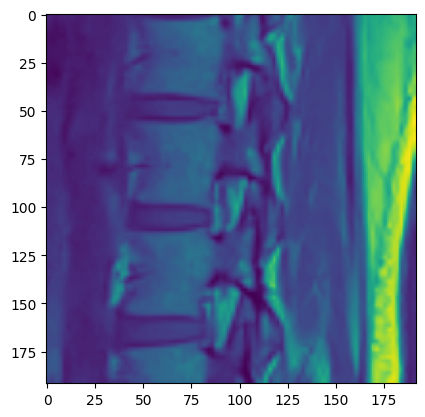

y stat: (192, 192) -0.9921569 0.78823537 -0.5038644 0.35361522



In [16]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_val)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=False,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==1:break
#     print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)

    y = x.numpy()[0,0,0,...]
    print(y.shape)
#     y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [17]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=45, n_classes=75, pretrained=False, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y
    
def get_last_layer(model, x):
    y = model.forward_features(x)
    print(y.shape)

In [18]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
#         nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
        



In [19]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=5,
            num_classes=1,
            features_only=False,
            drop_rate=0.,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()
            
        if 'densenet121' in backbone:
            hdim = 1024
            self.encoder.classifier = nn.Identity()
            
        if 'densenet161' in backbone:
            hdim = 2208
            self.encoder.classifier = nn.Identity()
        if 'densenet201' in backbone:
            hdim = 1920
            self.encoder.classifier = nn.Identity()


#         self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0., bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 75),
        )
        self.attention_layer = Attention(512, IN_CHANS)
#         self.transformer = Transformer(num_classes=75)
        

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        img_size = x.shape[3]
        x = x.view(bs * IN_CHANS, x.shape[2], img_size, img_size)
        feat = self.encoder(x)
        feat = feat.view(bs, IN_CHANS, -1)
#         feat_lstm, _ = self.lstm(feat)
#         feat_lstm = feat_lstm.contiguous().view(bs * 12, -1)
#         feat_lstm = self.head(feat_lstm)
#         feat_lstm = feat_lstm.view(bs, 12, 75).contiguous()
        atten = self.attention_layer(feat)
        out = self.head(atten)
#         feat = feat.permute(0, 2, 1)
#         trans = self.transformer(feat)
        return out

In [20]:
m = TimmModel(MODEL_NAME)
i = torch.randn(8, IN_CHANS, 5, 192, 192)
with torch.no_grad():
    out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-0.1636) tensor(0.2383)
torch.Size([75]) tensor(-0.2042) tensor(0.2253)
torch.Size([75]) tensor(-0.1440) tensor(0.1756)
torch.Size([75]) tensor(-0.1433) tensor(0.2142)
torch.Size([75]) tensor(-0.2812) tensor(0.2577)
torch.Size([75]) tensor(-0.2336) tensor(0.2445)
torch.Size([75]) tensor(-0.2394) tensor(0.1953)
torch.Size([75]) tensor(-0.2700) tensor(0.2591)


In [21]:
del m, i, out

In [ ]:
%time
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=2048)

val_losses = []
train_losses = []
df_tr, df_test = train_test_split(df, test_size=2/7, random_state=SEED)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    loss_scale = 1
    if NOT_DEBUG == False:
        if fold == 1: break;
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        print(len(trn_idx), len(val_idx))
        df_train = df.iloc[trn_idx]
        df_valid = df.iloc[val_idx]

        train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
        train_dl = DataLoader(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    pin_memory=False,
                    drop_last=True,
                    num_workers=0
                    )

        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=BATCH_SIZE*2,
                    shuffle=False,
                    pin_memory=False,
                    drop_last=False,
                    num_workers=0
                    )

        model = TimmModel(MODEL_NAME)
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
#         if os.path.exists(fname):
#             model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
#             model.load_state_dict(torch.load(fname))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LR*2, weight_decay=WD)

        warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
        num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=num_total_steps,
                                                    num_cycles=num_cycles)
#         scheduler = get_linear_schedule_with_warmup(optimizer,
#                                                     num_warmup_steps=warmup_steps,
#                                                     num_training_steps=num_total_steps)

        weights = torch.tensor([1.0, 2.0, 4.0])
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))
        criterion_cpu = nn.CrossEntropyLoss(weight=weights)
        best_loss = 1.2
        es_step = 0

        for epoch in range(1, EPOCHS+1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dl, leave=True) as pbar:
                optimizer.zero_grad()
                for idx, (x, t) in enumerate(pbar):  
                    op = ['nothing', 'nothing', 'nothing', 'nothing', 'nothing']
                    x = x.to(device)
                    t = t.to(device)
#                     t = torch.tensor(np.array(one_h(list(t.detach().cpu().numpy())))).to(device)
                    rc = random.sample(op, 1)
                    if rc[0] == 'mixup':
                        x = x.detach().cpu().numpy()
                        t = t.detach().cpu().numpy()
                        reference_data = [{'image':x[i], 'proba': t[i]} 
                                        for i in range(len(x))]
                        tr = A.Compose([A.MixUp(reference_data=reference_data,
                                              read_fn=read_fn, p=0.5)])
                        for i in range(len(x)):
                            transformed = tr(image=x[i], global_label=t[i])
                            x[i] = transformed['image']
                            t[i] = transformed['global_label']
                        
                        x = torch.tensor(x).to(device)
                        t = torch.tensor(t).to(device)
                        
                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
                            loss = loss + loss_scale * criterion(pred, gt) / N_LABELS
                        
                        if not math.isfinite(loss):
                            loss = torch.tensor(1.2 * loss_scale * GRAD_ACC, requires_grad=True)
                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC

                    
                    

                    pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
#                     scaler.scale(loss).backward()
                    loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
#                         scaler.step(optimizer)
#                         scaler.update()
                        optimizer.step()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()                    

            train_loss = total_loss/len(train_dl)
            print(f'train_loss:{train_loss/loss_scale:.6f}')
            train_losses.append(train_loss)
            total_loss = 0

            model.eval()
            y_preds, labels = [], []
            with tqdm(valid_dl, leave=True) as pbar:
                with torch.no_grad():
                    for idx, (x, t) in enumerate(pbar):

                        x = x.to(device)
                        t = t.to(device)

                        with autocast:
                            loss = 0
                            loss_ema = 0
                            y = model(x)
                            for col in range(N_LABELS):
                                pred = y[:,col*3:col*3+3]
                                gt = t[:,col]

                                loss = loss + criterion(pred, gt) / N_LABELS
                                y_pred = pred.float()
                                y_preds.append(y_pred.cpu())
                                labels.append(gt.cpu())

                            total_loss += loss.item()   

            val_loss = total_loss/len(valid_dl)
            y_preds = torch.cat(y_preds, dim=0)
            print(y_preds.shape)
            labels = torch.cat(labels)

            val_weighted_loss = criterion_cpu(y_preds, labels)
            print(f'val_loss:{val_loss:.6f}')
            val_losses.append(val_loss)
            if val_weighted_loss < best_loss:

                if device!='cuda:0':
                    model.to('cuda:0')                

                print(f'epoch:{epoch}, best weighted_logloss updated from {best_loss:.6f} to {val_weighted_loss:.6f}')
                best_loss = val_weighted_loss
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
                print(f'{fname} is saved')
                es_step = 0

                if device!='cuda:0':
                    model.to(device)

            else:
                es_step += 1
                if es_step >= EARLY_STOPPING_EPOCH:
                    print('early stopping')
                    break  
                                

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Jump fold 0
Jump fold 1
##############################
Start fold 2
##############################
1580 395
start epoch 1


  0%|          | 0/526 [00:00<?, ?it/s]

train_loss:0.971247


  0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9875, 3])
val_loss:0.819307
epoch:1, best weighted_logloss updated from 1.200000 to 0.894245
rsna24-cropped-results/best_wll_model_fold-2.pt is saved
start epoch 2


  0%|          | 0/526 [00:00<?, ?it/s]

train_loss:0.781786


  0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9875, 3])
val_loss:0.753001
epoch:2, best weighted_logloss updated from 0.894245 to 0.852754
rsna24-cropped-results/best_wll_model_fold-2.pt is saved
start epoch 3


  0%|          | 0/526 [00:00<?, ?it/s]

train_loss:0.757535


  0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9875, 3])
val_loss:0.747397
epoch:3, best weighted_logloss updated from 0.852754 to 0.850024
rsna24-cropped-results/best_wll_model_fold-2.pt is saved
start epoch 4


  0%|          | 0/526 [00:00<?, ?it/s]

train_loss:0.746498


  0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9875, 3])
val_loss:0.749125
start epoch 5


  0%|          | 0/526 [00:00<?, ?it/s]

train_loss:0.745022


  0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9875, 3])
val_loss:0.747852
start epoch 6


  0%|          | 0/526 [00:00<?, ?it/s]

failed to load on 3967802493, Sagittal T1
